In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.gridspec as gs
duration = 2.3 # [T] = ms -> [rate] = kHz

%matplotlib notebook

In [31]:
points_storage = np.load("points_validation.npy")
rates_storage = np.load("rates_validation.npy")
weights_hidden_storage = np.load("weights_hidden.npy")
weights_out_storage = np.load("weights_out.npy")
bias_storage = np.load("bias.npy")
# convert rates to Hz
rates_storage /= duration

learning_steps = rates_storage.shape[0]
n_steps = rates_storage.shape[1]
n_nrns = rates_storage.shape[2]
accuracy = np.zeros(learning_steps)
target = {1: 75/duration,
          2: 215/duration}
VMAX = 255/duration
VMIN = 0/duration
    
error = np.zeros((learning_steps, n_steps))
targets = np.zeros((learning_steps, n_steps))

Overview of Model Parameters

<IPython.core.display.Javascript object>


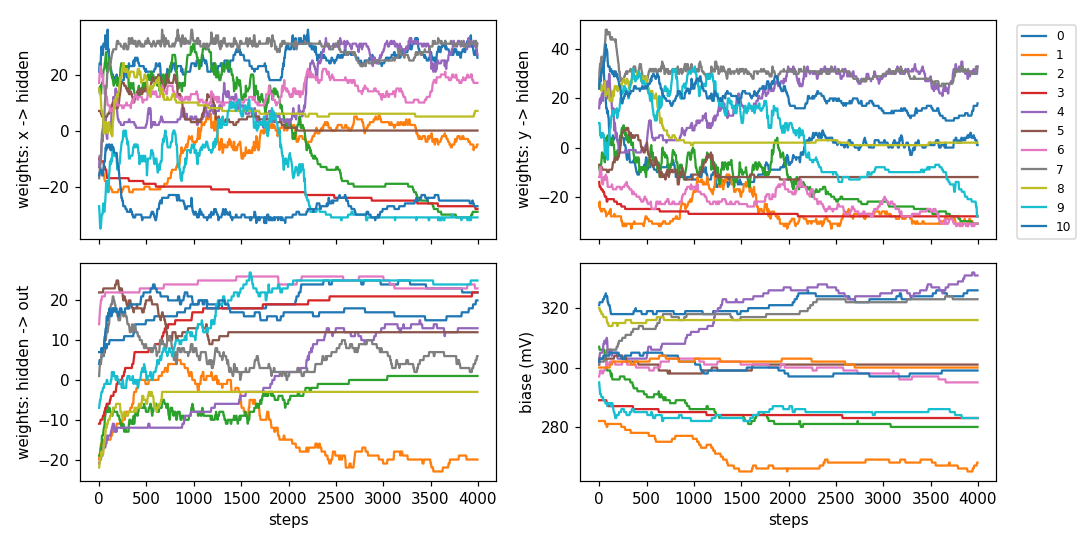

In [52]:
n_h_nrns = 11
n_nrns = 12
real_epochs = np.array(range(learning_steps))*5
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5), sharex=True)
axes = axes.flatten()
axes[0].plot(real_epochs, weights_hidden_storage[:,0,:])
axes[1].plot(real_epochs, weights_hidden_storage[:,1,:])
axes[2].plot(real_epochs, weights_out_storage)
axes[3].plot(real_epochs, bias_storage)
axes[0].set_ylabel("weights: x -> hidden")
#axes[0].legend(list(range(n_h_nrns)), fontsize=5)
axes[1].set_ylabel("weights: y -> hidden")
axes[2].set_xlabel("steps")
#axes[1].legend(list(range(n_h_nrns)), fontsize=5)
axes[2].set_ylabel("weights: hidden -> out")
axes[1].legend(list(range(n_h_nrns)), fontsize=8, loc=(1.05,0))
axes[3].set_ylabel("biase (mV)")
axes[3].set_xlabel("steps")
plt.subplots_adjust(hspace=0.15)
plt.tight_layout()
#axes[3].legend(list(range(n_nrns)), fontsize=5)
plt.savefig("model_parameters.png", transparent=True)

**Accuracy and Error**

In [15]:
def get_accuracy(rates, patterns, decision_boundary, n_steps):
    true_pattern_high = sum((rates > decision_boundary) & (patterns == 2))
    true_pattern_low = sum((rates <= decision_boundary) & (patterns == 1))
    return (true_pattern_high + true_pattern_low) / n_steps


In [16]:
DECISION_BOUNDARY = (target[2] + target[1])/2
for l_step in range(learning_steps):
    rates = rates_storage[l_step]
    points = points_storage[l_step]    
    # accuracy
    #decision_boundary = np.median(rates[:,-1])
    accuracy[l_step] = get_accuracy(rates[:,11], points[:,2],DECISION_BOUNDARY, n_steps)

    # error
    targets[l_step] = np.array([target[pattern] for pattern in points[:,2]])
    error[l_step] = rates[:,11] - targets[l_step]

norm = np.linalg.norm(error, axis=1)
mean_error = norm/n_steps
rmse = norm/np.sqrt(n_steps)

<IPython.core.display.Javascript object>


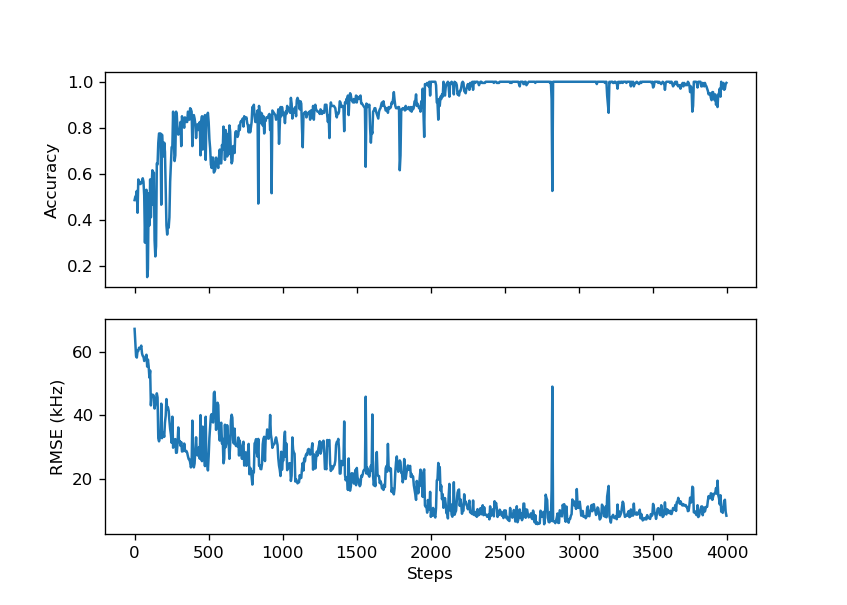

In [30]:
real_epochs = np.array(range(len(accuracy)))*5
fig1, axes = plt.subplots(nrows=2, sharex = True, figsize=(7,5))
axes[0].plot(real_epochs, accuracy)
axes[0].set_ylabel("Accuracy")
#axes[0].set_xlabel("Steps")
axes[1].plot(real_epochs, rmse)
axes[1].set_ylabel("RMSE (kHz)")
axes[1].set_xlabel("Steps")

#ig1.suptitle("Learning Performance")
plt.subplots_adjust(hspace=0.15)
plt.show()
plt.savefig("learning_performance.png", bbox_inches="tight", transparent=True)

<IPython.core.display.Javascript object>


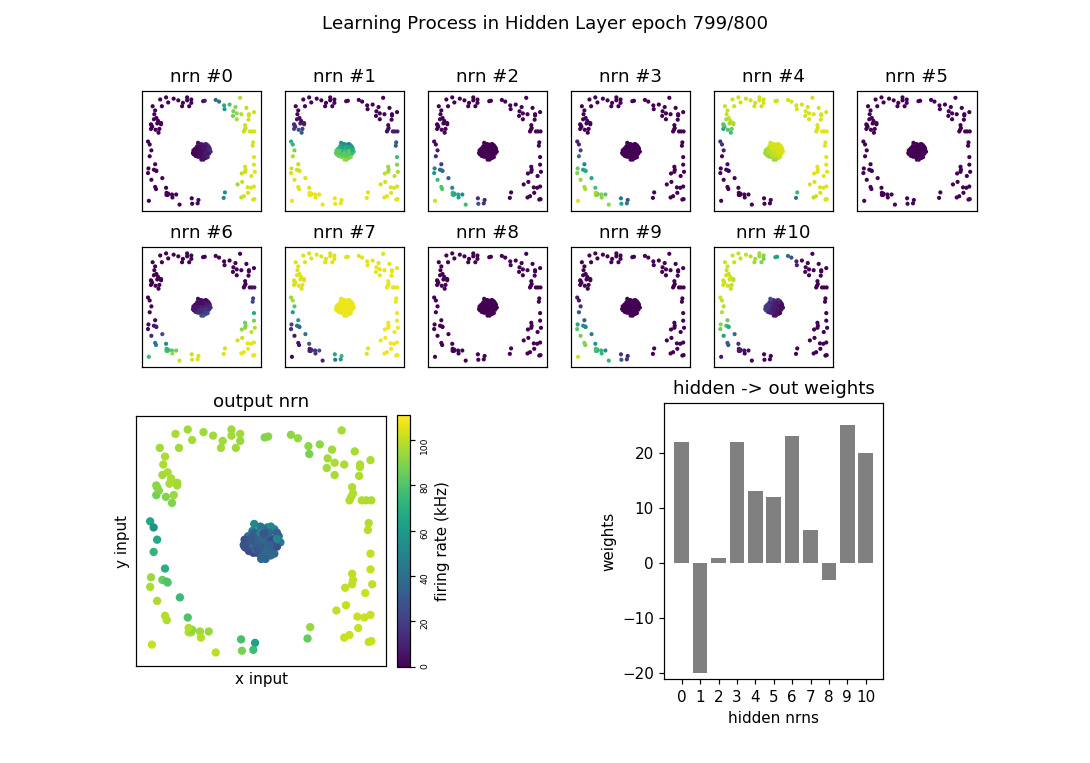

In [9]:
###### general plot settings #######
fig = plt.figure(figsize=(10,7))
shape = (4,6)
wcolor = "grey"
grid = gs.GridSpec(*shape, wspace=0.1, hspace=0.3)

def replot_weights(fig, weights, ax_idx=13):
    fig.axes[ax_idx].patches = []
    fig.axes[ax_idx].bar(np.arange(n_h_nrns), weights, width, color=wcolor, label="weight")


def replot_fire_rate(fig, points, rates, n_nrns, l_step):
    for i in range(n_nrns):
        fig.axes[i].collections = []
        s = 3 if i < 11 else 20
        fig.axes[i].scatter(points[:,0], points[:,1], c=rates[:,i], s=s,
                vmin=VMIN, vmax=VMAX)
    
    fig.suptitle("Learning Process in Hidden Layer epoch {}/{}".format(l_step, learning_steps))
    fig.canvas.draw()

########## INIT FIRE RATE PLOT ###############
# data
rates = rates_storage[0]
points = points_storage[0]

for i in range(n_nrns):
    if i < (n_nrns-1):
        ax = fig.add_subplot(grid[np.int(i/6),i%6])
        title = "nrn #{}".format(i)
        s = 3
    else:
        ax = fig.add_subplot(grid[2:,0:2])
        title = "output nrn"
        s = 20
        ax.set_ylabel("y input")
        ax.set_xlabel("x input")
    ax.set_title(title)
    ax.set_aspect(1.0)

    ax.set_xticks([])
    ax.set_yticks([])
    sc = ax.scatter(points[:,0], points[:,1], c=rates[:,i], s=s,
                    vmin=VMIN, vmax=VMAX)
    #ax.tick_params(axis='both', which='minor', labelsize=6)
    
    if i == 11:
        cbar = fig.colorbar(sc, fraction=0.046, pad=0.04, label="firing rate (kHz)")
        cbar.ax.tick_params(labelsize=6, rotation = 90)
    fig.suptitle("Learning Process in Hidden Layer epoch {}/{}".format(0, learning_steps))
    fig.canvas.draw()
    
######### INIT WEIGHTS PLOT ###################
ax = fig.add_subplot(grid[2:,3:])
weights = weights_out_storage[0]
width = 0.8
ymax_w = np.amax(weights_out_storage)+2
ymin_w = np.amin(weights_out_storage)+2
n_h_nrns = weights.shape[0]
ax.set_aspect(.3)
ax.set_xlabel("hidden nrns")
ax.set_xticks(list(range(n_h_nrns)))
ax.set_ylabel("weights")
ax.set_ylim(ymin_w, ymax_w)
ax.set_title("hidden -> out weights")
ax.bar(np.arange(n_h_nrns), weights, width, color=wcolor, label="weight")
    
############# LOOP THE REST ###################
for l_step in range(1,800, 1):
    rates = rates_storage[l_step]
    points = points_storage[l_step]
    replot_fire_rate(fig, points, rates, n_nrns, l_step)
    
    weights = weights_out_storage[l_step]
    replot_weights(fig, weights, ax_idx=12+1)

In [9]:
l_step = 1
rates = rates_storage[l_step]
points = points_storage[l_step]

<IPython.core.display.Javascript object>


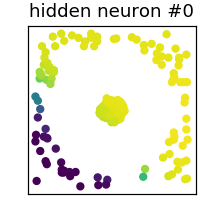

In [10]:
for i in range(1):
    fig = plt.figure(figsize=(2,2))
    plt.scatter(points[:,0], points[:,1], c=rates[:,i], s=s,
                    vmin=VMIN, vmax=VMAX)
    plt.xticks([])
    plt.yticks([])
    plt.title("hidden neuron #{}".format(i))
    plt.axis('square')
    plt.savefig("h_neuron_{}_{}.png".format(l_step, i), bbox_inches="tight")

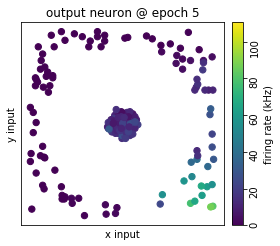

In [12]:
fig = plt.figure(figsize=(4,4))
sc = plt.scatter(points[:,0], points[:,1], c=rates[:,11], s=40,
                vmin=VMIN, vmax=VMAX)
cbar = fig.colorbar(sc, fraction=0.046, pad=0.04, label="firing rate (kHz)")
cbar.ax.tick_params(rotation = 90)
plt.xticks([])
plt.yticks([])
plt.ylabel("y input")
plt.xlabel("x input")
plt.title("output neuron @ epoch {}".format(l_step*5))
plt.axis('square')
plt.tight_layout()
plt.savefig("output_neuron_{}.png".format(l_step*5))

In [21]:
targets[0,0:10]

array([93.47826087, 93.47826087, 32.60869565, 93.47826087, 93.47826087,
       32.60869565, 93.47826087, 93.47826087, 93.47826087, 93.47826087])

<IPython.core.display.Javascript object>


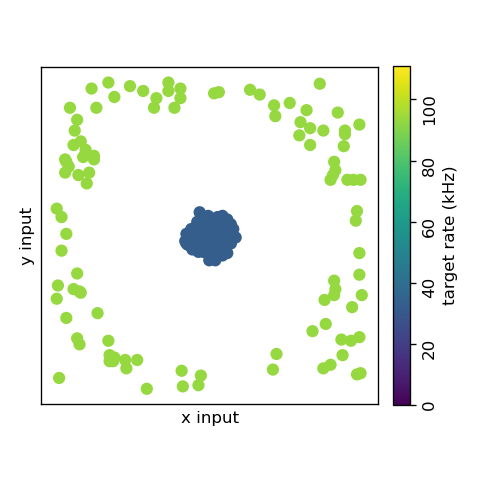

In [20]:
fig = plt.figure(figsize=(4,4))
sc = plt.scatter(points[:,0], points[:,1], c=targets[0,:], s=40,
                vmin=VMIN, vmax=VMAX)
cbar = fig.colorbar(sc, fraction=0.046, pad=0.04, label="target rate (kHz)")
cbar.ax.tick_params(rotation = 90)
plt.xticks([])
plt.yticks([])
plt.ylabel("y input")
plt.xlabel("x input")
plt.axis('square')
plt.tight_layout()
plt.savefig("targets.png", bbox_inches="tight", transparent = True) 

<IPython.core.display.Javascript object>


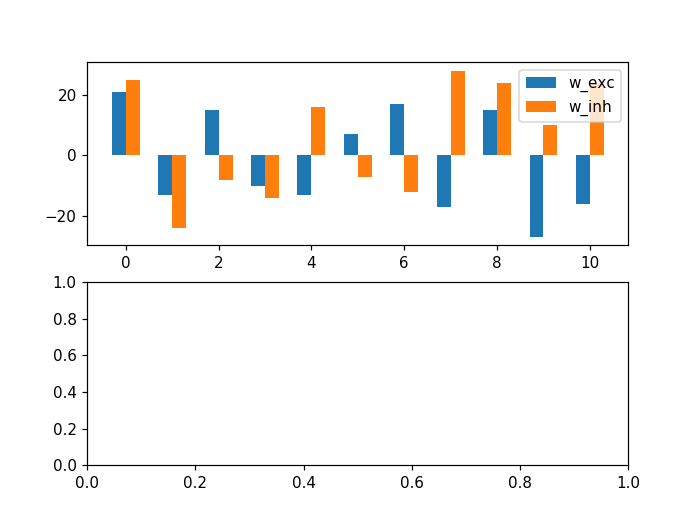

In [11]:
# input -> hidden
f, axes = plt.subplots(nrows=2)
width = 0.3
n_h_nrns = weights_hidden_storage.shape[2]
weights_hidden = weights_hidden_storage[i]
axes[0].bar(np.arange(n_h_nrns) - width/2, weights_hidden[0,:], width, label="w_exc")
axes[0].bar(np.arange(n_h_nrns) + width/2, weights_hidden[1,:], width, label="w_inh")
axes[0].legend()

LATEX TIKZ CODE GENERATOR

In [125]:
e = 0
weigths = weights_out_storage[np.int(e/5)]
abs_w = np.abs(weigths)/10
color_dict = {-1: "blue",
              0: "grey",
              1: "red"}
apply_color_dict = lambda x: color_dict[x]
color = [color_dict[w] for w in np.sign(weights)]

# input
input_weights = weights_hidden_storage[np.int(e/5)]
linewidth = np.abs(input_weights)/10
color_input = [list(map(apply_color_dict, weights)) for weights in np.sign(input_weights)]

In [180]:
epochs = [5] + [500*i for i in range(1,9)]

for n, epoch in enumerate(epochs):
    lines = []
    e = epoch - 5
    weigths = weights_out_storage[np.int(e/5)]
    abs_w = np.abs(weigths)/10
    color_dict = {-1: "blue",
                  0: "gray",
                  1: "red"}
    apply_color_dict = lambda x: color_dict[x]
    color = [color_dict[w] for w in np.sign(weights)]

    # input
    input_weights = weights_hidden_storage[np.int(e/5)]
    linewidth = np.abs(input_weights)/10
    color_input = [list(map(apply_color_dict, weights)) for weights in np.sign(input_weights)]
    
    lines.append("\\begin{tikzpicture}")
    #draw nodes
    lines.append("\t\\node (input0) at (2,6.0) {\\includegraphics[width=2cm]{learning_process/input_x_map.png}};") 
    lines.append("\t\\node (input1) at (8,6.0) {\\includegraphics[width=2cm]{learning_process/input_y_map.png}};")
    
    for i in range(11):
        lines.append("\t\\node (hidden{}) at ({}.0,3.0) {{\includegraphics[width=1cm]{{learning_process/h_neuron_{}_{}.png}}}};".format(i, i,epoch, i+1))
    lines.append("")
    lines.append("\t\\node (out{}) at (5.5,0.0) {{\includegraphics[width=3.6cm]{{learning_process/output_neuron_{}.png}}}};".format(epoch,epoch))
    
    # draw connectors
    for i in range(11):
        lines.append("\t\\draw[-stealth,{}!100!white,line width={}pt] (input0.south) -- (hidden{}.north);".format(color_input[0][i], linewidth[0, i], i))
        lines.append("\t\\draw[-stealth,{}!100!white,line width={}pt] (input1.south) -- (hidden{}.north);".format(color_input[1][i], linewidth[1, i], i))
    
    for i in range(11):
        lines.append("\t\\draw[-stealth,line width={}pt, color={} ] (hidden{}.south) -- (out{});".format(abs_w[i],color[i], i,epoch))
    lines.append("\\end{tikzpicture}")

    with open("learning_process_{}.tex".format(n), "w+") as f:
        f.writelines("%s \n" % line for line in lines)


    

In [182]:
lines = []
for i,_ in enumerate(epochs):
    lines.append("\\begin{{frame}}{{Learning Process Epoch {}/{}}}".format(_, epochs[-1]))
    lines.append("\t\\centering")
    lines.append("\t\\scalebox{{.9}}{{\\input{{learning_process/learning_process_{}.tex}}}}".format(i))
    lines.append("\\end{frame}")

with open("learning_process_frames.tex", "w+") as f:
    f.writelines("%s \n" % line for line in lines)

In [157]:
lines

['\\begin{frame}{Learning Process}']

**Inputs**

In [76]:
n_refrac = 5
n_samples = 1000
time = n_samples * (44e-5)
spiketrain_x = np.zeros(n_samples)
spiketrain_y = np.zeros(n_samples)
poisson_dist = np.random.poisson(12,size=n_samples)
for i,p in enumerate(poisson_dist):
    if i%4 == 0 and p < 10:
        spiketrain_x[i] = i 
    elif i%4 == 1 and p < 10:
        spiketrain_y[i] = i
    else:
        pass
    

In [77]:
print(sum(spiketrain_x > 0), sum(spiketrain_y > 0), "in kHz")

57 57 in kHz


<IPython.core.display.Javascript object>


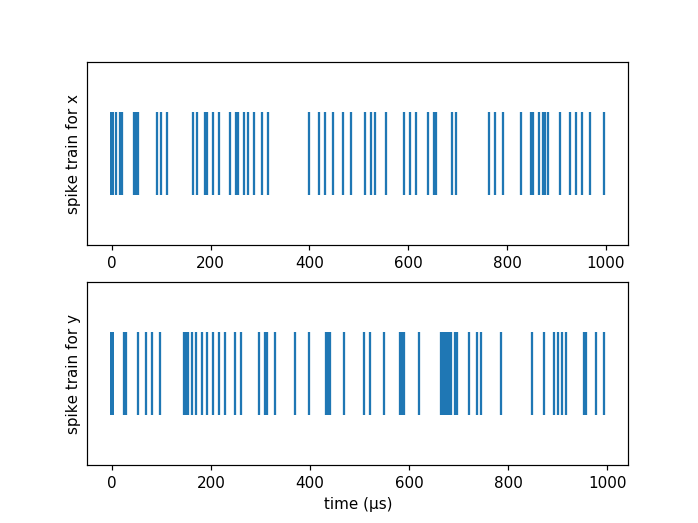

In [78]:
fig, axes = plt.subplots(nrows=2)
axes[0].eventplot(spiketrain_x)
axes[1].eventplot(spiketrain_y)
axes[1].set_xlabel("time (µs)")
for i, row in enumerate(["x", "y"]):
    axes[i].set_yticks([])
    #axes[i].set_xticks([])
    axes[i].set_ylabel("spike train for {}".format(row))
plt.savefig("input_spiketrains.png", bbox_inches="tight")

In [80]:
def points_to_rates(points):
    input_rate = 500/2.3
    rates = input_rate*((128 + points[:,:2])/128)
    return rates

In [81]:
input_rates = points_to_rates(points)
d_input_points = 10
map_points = np.vstack([np.arange(-128,127,d_input_points), np.arange(-128,127,d_input_points)]).T
input_rates_map = points_to_rates(map_points)
VMIN_INPUT = np.amin(input_rates)
VMAX_INPUT = np.amax(input_rates)

<IPython.core.display.Javascript object>


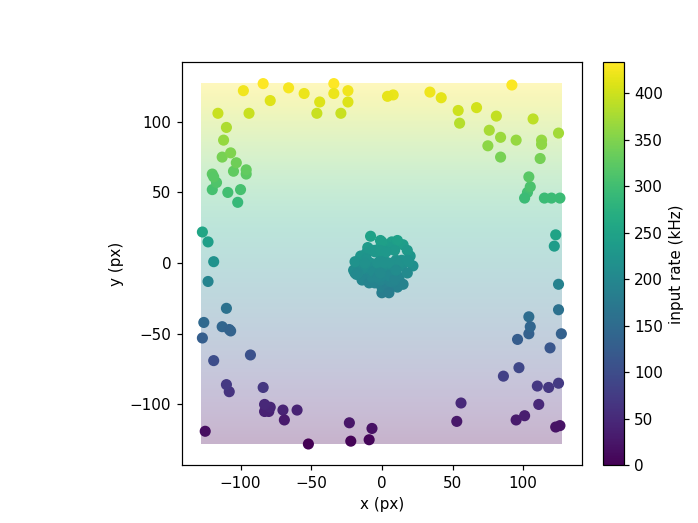

In [82]:
fig = plt.figure()
image = np.arange(65536).reshape((256, 256))
im = plt.imshow(image, origin='lower', alpha=0.3, extent=[-128, 127, -128, 127])
plt.xlabel("x (px)")
plt.ylabel("y (px)")
sc = plt.scatter(points[:,0],points[:,1], c=input_rates[:,1], s=40,
                vmin=VMIN_INPUT, vmax=VMAX_INPUT)

cbar = fig.colorbar(sc, fraction=0.046, pad=0.04, label="input rate (kHz)")
plt.savefig("input_y_map.png", bbox_inches="tight")

<IPython.core.display.Javascript object>


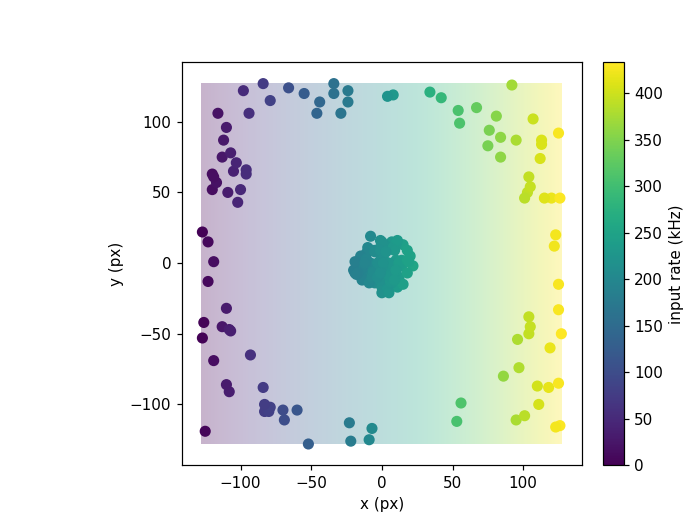

In [84]:
fig = plt.figure()
image = np.arange(65536).reshape((256, 256)).T
im = plt.imshow(image, origin='middle', alpha=0.3, extent=[-128, 127, -128, 127])
plt.xlabel("x (px)")
plt.ylabel("y (px)")
sc = plt.scatter(points[:,0], points[:,1], c=input_rates[:,0], s=40,
                vmin=VMIN_INPUT, vmax=VMAX_INPUT)

cbar = fig.colorbar(sc, fraction=0.046, pad=0.04, label="input rate (kHz)")
plt.savefig("input_x_map.png", bbox_inches="tight")

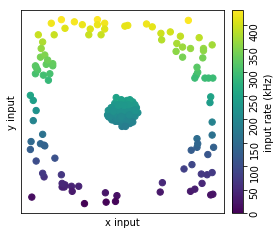

In [100]:
fig = plt.figure(figsize=(4,4))
sc = plt.scatter(points[:,0], points[:,1], c=input_rates[:,1], s=40,
                vmin=VMIN_INPUT, vmax=VMAX_INPUT)
cbar = fig.colorbar(sc, fraction=0.046, pad=0.04, label="input rate (kHz)")
cbar.ax.tick_params(rotation = 90)
plt.xticks([])
plt.yticks([])
plt.ylabel("y input")
plt.xlabel("x input")
plt.axis('square')
plt.tight_layout()